In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy import stats
import matplotlib.ticker as ticker
import os
from reload_recursive import reload_recursive
import patsy
from pyprocessmacro import Process
from statsmodels.stats.mediation import Mediation
from statsmodels.miscmodels.ordinal_model import OrderedModel
from pingouin import mediation_analysis

from mri_data import file_manager as fm
import helpers

In [24]:
reload_recursive(helpers)

## Setup

In [25]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
showfigs = False
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.precision = 3
colors = helpers.get_colors()

In [26]:
df = pd.read_csv(data_dir / "t1_2_data_full.csv")
df = df.set_index("subid")

df = helpers.set_dz_type5(df)
df = helpers.set_dz_type3(df)
df = helpers.set_dz_type2(df)
df = helpers.fix_edss(df)
df = helpers.clean_df(df)
df = helpers.set_has_prl(df)

keep_cols = [
    "subject",
    "age",
    "sex",
    "ms_type",
    "dz_type2",
    "dz_type3",
    "dz_type5",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "DMT_score",
    "DMT_hx_all",
    "flair_contrast",
    "thalamus",
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "lesion_count",
    "lesion_vol_cubic",
    "PRL",
    "HAS_PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume", 
    "pituitary_volume"
]

df = df.loc[:, keep_cols]
df = pd.concat((df, pd.get_dummies(df["sex"], dtype="int")), axis=1)
df["Intercept"] = 1

In [27]:
df.loc[:, "lesion_vol_logtrans"] = np.log(df["lesion_vol_cubic"])
df.loc[:, "edss_sqrt"] = np.sqrt(df["EDSS"].astype("float"))
df.loc[:, "msss_sqrt"] = np.sqrt(df["MSSS"])
df.loc[:, "armss_sqrt"] = np.sqrt(df["ARMSS"])
df.loc[:, "gmsss_sqrt"] = np.sqrt(df["gMSSS"])

In [28]:
vars = [
    "age",
    "Female",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "edss_sqrt",
    "msss_sqrt",
    "armss_sqrt",
    "gmsss_sqrt",
    "DMT_score",
    "DMT_hx_all",
    "thalamus",
    "brain",
    "white",
    "grey",
    "cortical_thickness",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "HAS_PRL",
    "tiv",
    "choroid_volume",
    "pineal_volume",
    "pituitary_volume"
]

for var in vars:
    df[var] = pd.to_numeric(df[var])

In [29]:
vars_to_center = ["edss_sqrt", "lesion_vol_logtrans", "lesion_vol_cubic", "dzdur", "choroid_volume"]

for var in vars_to_center:
    df[f"{var}_cent"] = df[var] - df[var].mean()

centered_vars = [f"{var}_cent" for var in vars_to_center]
vars.extend(centered_vars)

In [30]:
vars_to_scale = [
    "age",
    "dzdur",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
]

df_scale = df.copy()
df_scale[vars_to_scale] = df_scale[vars_to_scale] / df_scale[vars_to_scale].mean()

In [31]:
df_ms = df.loc[df['dz_type2'] == "MS"]
df_scale_ms = df_scale.loc[df['dz_type2'] == "MS"]

df_z = df[vars].astype("float")
df_z[df.columns[~df.columns.isin(vars)]] = df[df.columns[~df.columns.isin(vars)]]
df_z = df_z[df.columns]
df_z[vars] = df_z[vars].apply(stats.zscore, nan_policy="omit")

data = df[vars].astype("float")
data_z = data[vars].apply(stats.zscore, nan_policy="omit")

data_ms = df.loc[df["dz_type5"].isin(["RMS", "PMS"]), :]
data_ms = data_ms[vars].astype("float")
data_ms_z = data_ms[vars].apply(stats.zscore, nan_policy="omit")

# remove outliers
df_z_noOut = df_z.copy()
df_z_noOut.loc[np.abs(df_z_noOut['pineal_volume']) >= 4, "pineal_volume"] = None

## Analysis

### Pineal Volume

In [32]:
model_data = df_z.copy()
model_data = model_data[model_data['dz_type2'].isin(["MS", "!MS"])]
model_data = model_data.drop([1548], axis=0)
res = sm.OLS.from_formula(
    "pineal_volume ~ dz_type2 + age + tiv + Female + lesion_vol_cubic", data=model_data
).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.080
R2_adj: 0.070
                   coef          p
Intercept         0.154  1.137e-01
dz_type2[T.MS]   -0.205  5.405e-02
age              -0.098  1.306e-02
tiv               0.072  1.122e-01
Female            0.027  5.487e-01
lesion_vol_cubic -0.166  2.916e-05


In [33]:
model_data = df_z.copy()
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
res = sm.OLS.from_formula("pineal_volume ~ dz_type5 + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.047
R2_adj: 0.038
                  coef      p
Intercept       -0.245  0.012
dz_type5[T.RMS]  0.231  0.040
Female          -0.017  0.728
age             -0.108  0.015
tiv              0.054  0.268


See how pineal volume changes with various imaging findings

In [34]:
model_data = df_z
# model_data = df_z[df_z['dz_type5'].isin(["RMS", "PMS"])]
# model_data = df_z[df_z['dz_type5'] == "OIND"]

outcomes = ["lesion_vol_cubic", "PRL", "thalamus", "brain", "grey", "white", "cortical_thickness"]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

for outcome in outcomes:
    formula = f"{outcome} ~ pineal_volume + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[outcome] = res.pvalues['pineal_volume']
    coefs[outcome] = res.params['pineal_volume']

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
print(regression_results)

                     coef      pvals      p_fdr
lesion_vol_cubic   -0.195  9.017e-06  4.647e-05
PRL                -0.040  3.715e-01  4.874e-01
thalamus            0.165  1.991e-05  4.647e-05
brain               0.032  4.178e-01  4.874e-01
grey                0.066  8.089e-02  1.416e-01
white              -0.025  5.636e-01  5.636e-01
cortical_thickness  0.167  1.763e-05  4.647e-05


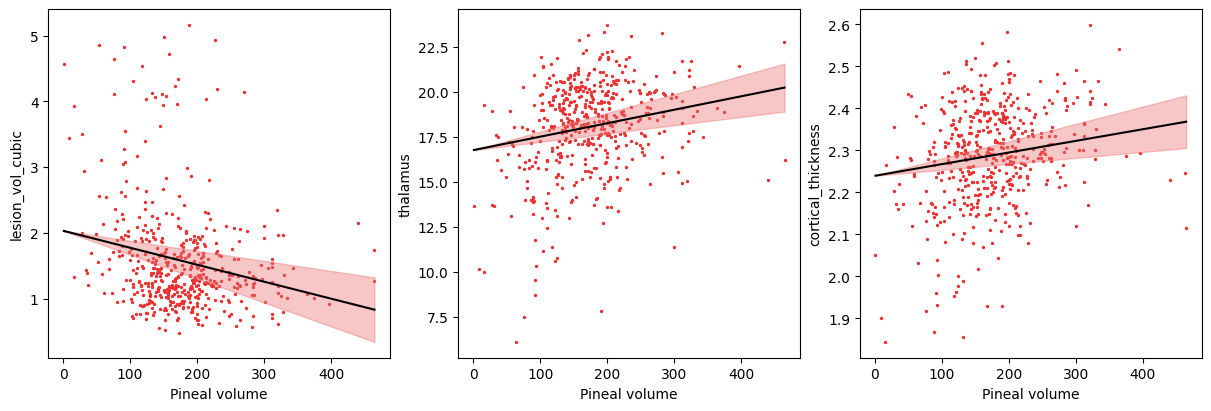

In [35]:
outcomes = ["lesion_vol_cubic", "thalamus", "cortical_thickness"]

fig, axs = plt.subplot_mosaic([outcomes], 
                               figsize=(12, 4),
                               layout='constrained',
                               )

plot_data = data.copy()
plot_data = plot_data[data_z['pineal_volume'] < 5]

dark_color = colors['dark red1']
light_color = colors['light red1']
keep_xticks = outcomes
for outcome in outcomes:
    formula = f"{outcome} ~ pineal_volume + {covariates}"
    res = sm.OLS.from_formula(formula, data=plot_data).fit()
    x, y_pred, y_lims = helpers.get_regression_y(plot_data, res, "pineal_volume", outcome)
    axs[outcome].scatter(plot_data['pineal_volume'], plot_data[outcome], s=2, color=dark_color)
    axs[outcome].plot(x, y_pred, color='black')
    axs[outcome].fill_between(x, y_lims[0], y_lims[1], alpha=0.4, color=light_color)
    axs[outcome].set_ylabel(outcome)
    if outcome not in keep_xticks:
        axs[outcome].set_xlabel("")
        axs[outcome].set_xticklabels([])
    else:
        axs[outcome].set_xlabel("Pineal volume")

In [36]:
moderation_model = sm.OLS.from_formula("thalamus ~ lesion_vol_cubic*pineal_volume + tiv + age + Female", data=data_z)
res = moderation_model.fit()
summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues.round(3)})
print("R2:     {:0.3}".format(res.rsquared))
print("R2_adj: {:0.3}".format(res.rsquared_adj))
print(summary)

R2:     0.415
R2_adj: 0.408
                                 coef      p
Intercept                       0.027  0.446
lesion_vol_cubic               -0.300  0.000
pineal_volume                   0.127  0.001
lesion_vol_cubic:pineal_volume  0.125  0.002
tiv                            -0.027  0.517
age                            -0.341  0.000
Female                          0.197  0.000


Other correlations

In [37]:
model_data = df_z.copy()
# model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
res = sm.OLS.from_formula("pineal_volume ~ thalamus + Female + age + tiv", data=model_data).fit()

summary = pd.DataFrame({'coef': res.params, 'p': res.pvalues})
print("R2:     {:0.3f}".format(res.rsquared))
print("R2_adj: {:0.3f}".format(res.rsquared_adj))
print(summary)

R2:     0.050
R2_adj: 0.042
                coef          p
Intercept  3.556e-17  1.000e+00
thalamus   2.220e-01  1.991e-05
Female    -2.300e-02  6.760e-01
age       -1.312e-02  7.944e-01
tiv        3.676e-02  4.929e-01


In [38]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS"])]

res = sm.OLS.from_formula("pineal_volume ~ EDSS + Female + age + tiv", data=model_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          pineal_volume   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     4.284
Date:                Mon, 10 Mar 2025   Prob (F-statistic):            0.00210
Time:                        14:23:18   Log-Likelihood:                -2243.7
No. Observations:                 397   AIC:                             4497.
Df Residuals:                     392   BIC:                             4517.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    161.0236     56.147      2.868      0.0

In [39]:
model_data = df[df['dz_type5'].isin(["RMS", "PMS"])]

res = sm.OLS.from_formula("pineal_volume ~ MSSS + DMT_hx_all + dz_type5 + lesion_vol_cubic + PRL + Female + age + tiv", data=model_data).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          pineal_volume   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     3.691
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           0.000368
Time:                        14:23:18   Log-Likelihood:                -2126.4
No. Observations:                 376   AIC:                             4271.
Df Residuals:                     367   BIC:                             4306.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          145.1154     60.193  

In [40]:
model_data = df_z.copy()
model_data = model_data.loc[df['dz_type5'].isin(["RMS", "PMS"]), :]

Do all the univariate regressions with age, sex, and TIV as covariates

In [41]:
predictors = ["pineal_volume", "lesion_vol_cubic", "PRL", "thalamus", "grey", "white", "cortical_thickness"]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

for predictor in predictors:
    formula = f"edss_sqrt ~ {predictor} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[predictor] = res.pvalues[predictor]
    coefs[predictor] = res.params[predictor]

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results

,coef,pvals
pineal_volume,-0.062,2.565e-01
lesion_vol_cubic,0.158,5.307e-04
PRL,0.106,1.272e-02
thalamus,-0.264,1.305e-07
grey,-0.095,7.531e-02
white,-0.013,7.872e-01
cortical_thickness,-0.232,4.861e-06


## Compare Resegmented

In [13]:
df2 = pd.read_csv(data_dir / "t1_2_data_full.csv")
df2 = df2.set_index("subid")

df2 = helpers.set_dz_type5(df2)
df2 = helpers.set_dz_type3(df2)
df2 = helpers.set_dz_type2(df2)
df2 = helpers.fix_edss(df2)
df2 = helpers.clean_df(df2)
df2 = helpers.set_has_prl(df2)

df2 = df2.loc[:, keep_cols]
df2 = pd.concat((df2, pd.get_dummies(df2["sex"], dtype="int")), axis=1)
df2["Intercept"] = 1

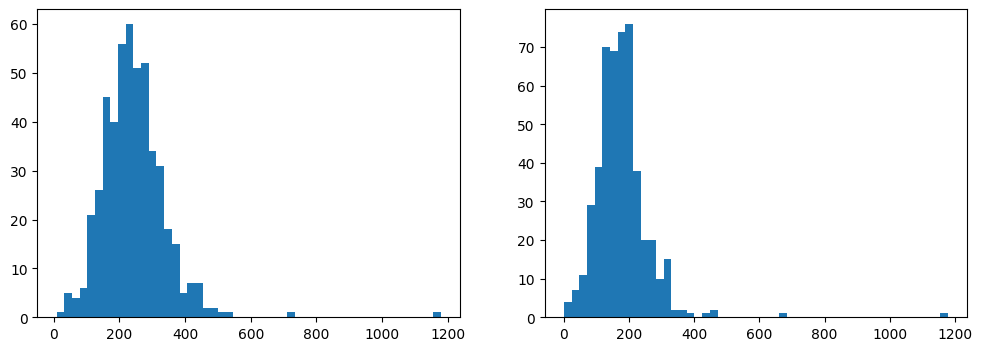

In [20]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(df['pineal_volume'], bins=50)
ax[1].hist(df2['pineal_volume'], bins=50)
plt.show()

<BarContainer object of 2 artists>

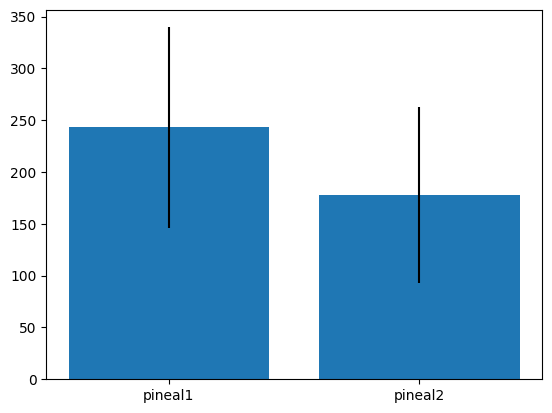

In [22]:
plt.bar(["pineal1", "pineal2"], [df['pineal_volume'].mean(), df2['pineal_volume'].mean()],
        yerr=[df['pineal_volume'].std(), df2['pineal_volume'].std()])